In [1]:
import snap
import numpy as np
import copy
import csv
import matplotlib.pyplot as plt
import copy
import pandas as pd
from matplotlib.pyplot import figure
% matplotlib inline
print snap.__file__

snap.pyc


In [2]:
def readGraph(FILEPATH): 
    Graph_dict = {}
    for i in range(1, 915):
        G = snap.PNEANet.New()
        file_name = FILEPATH + str(i) + "_edges.txt"
        firstline = True
        try:
            with open(file_name) as csv_file:
                edge_reader = csv.reader(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                edge_count = 0
                for row in edge_reader:
                    if firstline:
                        firstline = False
                        continue
                    if not G.IsNode(int(row[0])):
                        G.AddNode(int(row[0]))
                    if not G.IsNode(int(row[1])):
                        G.AddNode(int(row[1]))
                    for _ in range(int(float(row[2]))):
                        G.AddEdge(int(row[0]), int(row[1]), edge_count)
                        edge_count += 1
                        G.AddEdge(int(row[1]), int(row[0]), edge_count)
                        edge_count += 1
            Graph_dict[i] = G
        except IOError:
            continue
            
    return Graph_dict

In [ ]:
def readGraph2(FILEPATH): 
    dir_Graph_dict = {}
    undir_Graph_dict = {}
    for i in range(1, 915):
        G_dir = snap.PNEANet.New()
        G_undir = snap.PNEANet.New() 
        file_name = FILEPATH + str(i) + "_edges.txt"
        firstline = True
        try:
            with open(file_name) as csv_file:
                edge_reader = csv.reader(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                edge_count = 0
                undir_edge_count = 0
                for row in edge_reader:
                    if firstline:
                        firstline = False
                        continue
                    if not G_dir.IsNode(int(row[0])):
                        G_dir.AddNode(int(row[0]))
                    if not G_dir.IsNode(int(row[1])):
                        G_dir.AddNode(int(row[1]))
                    for _ in range(int(float(row[2]))):
                        G_dir.AddEdge(int(row[0]), int(row[1]), edge_count)
                        edge_count += 1
                        G_dir.AddEdge(int(row[1]), int(row[0]), edge_count)
                        edge_count += 1
                    if not G_undir.IsNode(int(row[0])):
                        G_undir.AddNode(int(row[0]))
                    if not G_undir.IsNode(int(row[1])):
                        G_undir.AddNode(int(row[1]))
                    for _ in range(int(float(row[2]))):
                        G_undir.AddEdge(int(row[0]), int(row[1]), undir_edge_count)
                        undir_edge_count += 1
            dir_Graph_dict[i] = G_dir
            undir_Graph_dict[i] = G_undir
        except IOError:
            continue
    return dir_Graph_dict, undir_Graph_dict

In [3]:
def getEgonet(Node, Graph):
    newGraph = snap.PNEANet.New()
    outEdges = 0
    nbrIds = []
    
    # add all the nodes within Node's egonet to newGraph, add edges (Node, its neighbors)
    newGraph.AddNode(Node.GetId())
    for i in range(Node.GetOutDeg()):
        nbrId = Node.GetNbrNId(i)
        if not newGraph.IsNode(nbrId):
            newGraph.AddNode(nbrId)
            nbrIds.append(nbrId)
        newGraph.AddEdge(Node.GetId(), nbrId)

            
    
    # add edges between neighbors
    
    for nbrId in nbrIds: 
        nbrNode = Graph.GetNI(nbrId)
        for j in range(nbrNode.GetOutDeg()):
            nbrNbrId = nbrNode.GetNbrNId(j)
            if newGraph.IsNode(nbrNbrId):
                # add edgeslike (nbrId, Node), (nbrId, nbrnbrId)
                newGraph.AddEdge(nbrId, nbrNbrId)
            else:  
                outEdges = outEdges+1
    
    # weighted edges
    return newGraph, newGraph.GetEdges()/2.0, outEdges

In [4]:
def getNodeWithFeatures(Graph, degList):
    nodeWithFeatures = {NI.GetId() : [] for NI in Graph.Nodes()}

    for nodeId, features in nodeWithFeatures.iteritems():
        for item in degList:
            if item[0] == nodeId:
                features.append(item[1])
                break

        node = Graph.GetNI(nodeId)
        egonet, inEdges, outEdges = getEgonet(node, Graph)
        features.append(inEdges)
        features.append(outEdges)
    
    return nodeWithFeatures

In [5]:
def getRecursiveFeatures(k, ctrNodeId, G, nodeWithFeatures):
    newNodeWithFeatures = {key : [] for key in nodeWithFeatures}
    for key in newNodeWithFeatures:
        newNodeWithFeatures[key].extend(nodeWithFeatures[key])
        
    for i in range(k):
        # print i
        oldNodeWithFeatures = copy.deepcopy(newNodeWithFeatures)
        for key in newNodeWithFeatures:
            sumValue = np.zeros(len(newNodeWithFeatures[key]))
            keyNode = G.GetNI(key)
            for j in range(keyNode.GetOutDeg()):
                nbrId = keyNode.GetNbrNId(j)
                sumValue = sumValue + np.array(oldNodeWithFeatures[nbrId])

            if keyNode.GetOutDeg() == 0 :
                mean = np.zeros(len(newNodeWithFeatures[key]))
            else: 
                mean = sumValue*1.0/keyNode.GetDeg()
            # print "mean=", mean
            newNodeWithFeatures[key].extend(list(mean))
            newNodeWithFeatures[key].extend(list(sumValue))
    
    # print newNodeWithFeatures[9]
    # print "len=", len(newNodeWithFeatures[9])
    
    return newNodeWithFeatures
    

# Get Egonet Features For Largest in-degree

In [11]:

# graph_dict is with both in and out edges
graph_dict = readGraph("../dataset/edges/")

# result_egonet_mostIndegree[i][0-26]: maxDegNode feature
# result_egonet_mostIndegree[i][27-53]: 2toMaxDegNode feature
result_egonet_mostIndegree = {}
for i in graph_dict:
    print i
    G = graph_dict[i]
    OutDegV = snap.TIntPrV()
    snap.GetNodeOutDegV(G, OutDegV)
    
    # degList = [(NodeId, NodeOutDegree)]
    degList = []
    for item in OutDegV:
        degList.append((item.GetVal1(), item.GetVal2()))
    # sorted degree of all the nodes in this graph, starting from the node with its max degree
    degList.sort(key=lambda x: x[1], reverse=True)
    
    nodeWithFeatures = getNodeWithFeatures(G, degList)
    
    nodeId0 = degList[0][0]
    node0 = G.GetNI(nodeId0)
    newNodeWithFeatures = getRecursiveFeatures(2, nodeId0, G, nodeWithFeatures)
#     print "nodeId0 ", nodeId0
#     print "newNodeWithFeatures[nodeId0] ", newNodeWithFeatures[nodeId0]
    
    
    nodeId1 = degList[1][0]
    node1 = G.GetNI(nodeId1)
    newNodeWithFeatures = getRecursiveFeatures(2, nodeId1, G, nodeWithFeatures)
#     print "nodeId1 ", nodeId1
#     print "newNodeWithFeatures[nodeId1] ", newNodeWithFeatures[nodeId1]
    
    result_egonet_mostIndegree[i] = []
    result_egonet_mostIndegree[i].extend(newNodeWithFeatures[nodeId0])
    result_egonet_mostIndegree[i].extend(newNodeWithFeatures[nodeId1])
    # break
    


1
2
3
5
6
7
8
9
10
11
13
14
15
17
19
21
22
23
24
25
26
27
28
30
31
32
33
34
36
38
39
40
41
42
43
44
45
47
48
49
50
51
52
54
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
76
80
81
82
83
84
85
86
87
88
89
91
92
93
97
98
99
100
101
102
103
104
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
157
158
159
161
162
163
164
165
166
167
169
170
171
173
174
175
176
177
178
179
180
182
183
184
185
186
187
189
190
191
192
193
194
195
197
198
199
200
201
204
205
206
208
209
210
211
212
213
214
216
217
218
220
221
222
223
224
225
226
227
229
231
232
234
235
236
238
239
240
241
242
243
244
246
247
248
249
250
251
252
253
254
255
256
257
258
260
261
262
263
264
265
266
268
269
271
272
273
274
276
278
279
280
281
282
283
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
313
314
315
316
317
318
319
320

# calculate node2vec with p = 0.1 q = 1 --BFS

In [7]:
'''
Reference implementation of node2vec. 

Author: Aditya Grover

For more details, refer to the paper:
node2vec: Scalable Feature Learning for Networks
Aditya Grover and Jure Leskovec 
Knowledge Discovery and Data Mining (KDD), 2016
'''

import argparse
import numpy as np
import networkx as nx
import node2vec
from gensim.models import Word2Vec

def parse_args(string):
    '''
    Parses the node2vec arguments.
    '''
    parser = argparse.ArgumentParser(description="Run node2vec.")

    parser.add_argument('--input', nargs='?', default='graph/karate.edgelist',
                        help='Input graph path')

    parser.add_argument('--output', nargs='?', default='emb/karate.emb',
                        help='Embeddings path')

    parser.add_argument('--dimensions', type=int, default=128,
                        help='Number of dimensions. Default is 128.')

    parser.add_argument('--walk-length', type=int, default=80,
                        help='Length of walk per source. Default is 80.')

    parser.add_argument('--num-walks', type=int, default=10,
                        help='Number of walks per source. Default is 10.')

    parser.add_argument('--window-size', type=int, default=10,
                        help='Context size for optimization. Default is 10.')

    parser.add_argument('--iter', default=1, type=int,
                      help='Number of epochs in SGD')

    parser.add_argument('--workers', type=int, default=8,
                        help='Number of parallel workers. Default is 8.')

    parser.add_argument('--p', type=float, default=1,
                        help='Return hyperparameter. Default is 1.')

    parser.add_argument('--q', type=float, default=1,
                        help='Inout hyperparameter. Default is 1.')

    parser.add_argument('--weighted', dest='weighted', action='store_true',
                        help='Boolean specifying (un)weighted. Default is unweighted.')
    parser.add_argument('--unweighted', dest='unweighted', action='store_false')
    parser.set_defaults(weighted=False)

    parser.add_argument('--directed', dest='directed', action='store_true',
                        help='Graph is (un)directed. Default is undirected.')
    parser.add_argument('--undirected', dest='undirected', action='store_false')
    parser.set_defaults(directed=False)

    return parser.parse_args(string.split())

def read_graph():
    '''
    Reads the input network in networkx.
    '''
    if args.weighted:
        G = nx.read_edgelist(args.input, comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    else:
        G = nx.read_edgelist(args.input, comments='s', delimiter= ',', nodetype=int, create_using=nx.Graph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1

    if not args.directed:
        G = G.to_undirected()
    
    return G

def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [map(str, walk) for walk in walks]
    model = Word2Vec(walks, size=args.dimensions, window=args.window_size, min_count=0, sg=1, workers=args.workers, iter=args.iter)
    # model.wv.save_word2vec_format(args.output)
    
    return model.wv

def learn_neighbors(wv, target):
    tar = wv[target]
    score = []
    for i in range(1, 35):
        if str(i) != target:
            cur = wv[str(i)]
            sim = np.dot(cur, tar)
            score.append((i, sim))

    score.sort(key=lambda x: x[1], reverse=True)

    return score

def learn_distance(wv, target):
    tar = wv[target]
    score = []
    for i in range(1, 35):
        if str(i) != target:
            cur = wv[str(i)]
            dis = np.linalg.norm(tar - cur)
            score.append((i, dis))

    score.sort(key=lambda x: x[1], reverse=True)
    return score

def learn_sum(wv, length, nodes):
    sumVector = np.zeros(length)
    for i in nodes: 
        # normalized the vectors
        a = np.asarray(wv[str(i)], dtype=np.float64)
        sumVector += wv[str(i)]/np.linalg.norm(a)
#         a = np.asarray(np.exp(wv[str(i)]), dtype=np.float64)
#         sumVector += np.exp(wv[str(i)])/np.linalg.norm(a)
        
    return sumVector

def learn_avg(wv, length, nodes, num):
    avgVector = np.zeros(length)
    for i in nodes: 
        # normalized the vectors
        a = np.asarray(wv[str(i)], dtype=np.float64)
        avgVector += wv[str(i)]/np.linalg.norm(a)
#         a = np.asarray(np.exp(wv[str(i)]), dtype=np.float64)
#         avgVector += np.exp(wv[str(i)])/np.linalg.norm(a)
        
    return avgVector * 1.0/num
    
def main(args):
    '''
    Pipeline for representational learning for all nodes in a graph.
    '''
    nx_G = read_graph()
    G = node2vec.Graph(nx_G, args.directed, args.p, args.q)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(args.num_walks, args.walk_length)
    wv = learn_embeddings(walks)
    
    length = args.dimensions
    num = G.nodes()


In [33]:
def calculate_similarities(keyNode, keyVector, startIndex, graph_vectors):
    score_vectors = []
    for i in graph_vectors:
        if i != keyNode:
            cur = graph_vectors[i][startIndex:]
            dis = np.linalg.norm(np.array(keyVector) - np.array(cur))
            score_vectors.append((i, dis))

    score_vectors.sort(key=lambda x: x[1])
    return score_vectors

In [13]:
result_node2vec = {i:[] for i in graph_dict}
#result3 = {i:[] for i in graph_dict}
string = "--input ../dataset/edges/1_edges.txt --dimensions 32 --weighted --p 0.1 "
args = parse_args(string)

for i in graph_dict:
    print i
    args.input = "../dataset/edges/{}_edges.txt".format(i)
    nx_G = read_graph()
    G = node2vec.Graph(nx_G, args.directed, args.p, args.q)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(args.num_walks, args.walk_length)
    wv = learn_embeddings(walks)
    
    length = args.dimensions
    
    # print length
    num = len(nx_G.nodes())
    
    sumValue = learn_sum(wv, length, nx_G.nodes())
    avgValue = learn_avg(wv, length, nx_G.nodes(), num)
    

#     print len(avgValue)
#     a =[]
#     a.extend(sumValue)
#     a.extend(avgValue)
    
    
    result_node2vec[i].extend(sumValue)
    result_node2vec[i].extend(avgValue)

1
2
3
5
6
7
8
9
10
11
13
14
15
17
19
21
22
23
24
25
26
27
28
30
31
32
33
34
36
38
39
40
41
42
43
44
45
47
48
49
50
51
52
54
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
76
80
81
82
83
84
85
86
87
88
89
91
92
93
97
98
99
100
101
102
103
104
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
157
158
159
161
162
163
164
165
166
167
169
170
171
173
174
175
176
177
178
179
180
182
183
184
185
186
187
189
190
191
192
193
194
195
197
198
199
200
201
204
205
206
208
209
210
211
212
213
214
216
217
218
220
221
222
223
224
225
226
227
229
231
232
234
235
236
238
239
240
241
242
243
244
246
247
248
249
250
251
252
253
254
255
256
257
258
260
261
262
263
264
265
266
268
269
271
272
273
274
276
278
279
280
281
282
283
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
313
314
315
316
317
318
319
320

In [32]:
len(result_node2vec[1])

64

# use the average key2 to calculate similarities

In [59]:
def draw4graphs(score):
    # figure(num=None, figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')

    fig = plt.figure(figsize=(12,12), dpi=150)
    plt.subplot(2, 2, 1)

    G = nx.read_edgelist("../dataset/edges/2_edges.txt", comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    #nx.draw_networkx(G)
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1]
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=100)
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=1,alpha=0.7,edge_color='b',style='dotted')
    nx.draw_networkx_labels(G,pos,font_size=7,font_family='sans-serif')
    plt.axis('off')
    plt.title("Graph of network 2")

    plt.subplot(2, 2, 2)
    num1 = score[0][0]
    G = nx.read_edgelist("../dataset/edges/{}_edges.txt".format(num1), comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1]
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=40)
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=0.5,alpha=0.7,edge_color='b',style='dotted')
    nx.draw_networkx_labels(G,pos,font_size=4,font_family='sans-serif')
    plt.axis('off')
    plt.title("Graph of network {}".format(num1))

    plt.subplot(2, 2, 3)
    num2 = score[350][0]
    G = nx.read_edgelist("../dataset/edges/{}_edges.txt".format(num2), comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1]
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=100)
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=0.5,alpha=0.7,edge_color='b',style='dotted')
    nx.draw_networkx_labels(G,pos,font_size=5,font_family='sans-serif')
    plt.axis('off')
    plt.title("Graph of network {}".format(num2))

    plt.subplot(2, 2, 4)
    num3 = score[-1][0]
    G = nx.read_edgelist("../dataset/edges/{}_edges.txt".format(num3), comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1]
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=100)
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=0.5,alpha=0.7,edge_color='b',style='dotted')
    nx.draw_networkx_labels(G,pos,font_size=5,font_family='sans-serif')
    plt.axis('off')
    plt.title("Graph of network {}".format(num3))

    # plt.savefig("weighted_graph_example.png") 
    plt.show() # display

719

In [ ]:
startIndex = 32
key2 = result_node2vec[2][startIndex:]
score_node2vec = calculate_similarities(2, key2, startIndex, result_node2vec)
score_node2vec

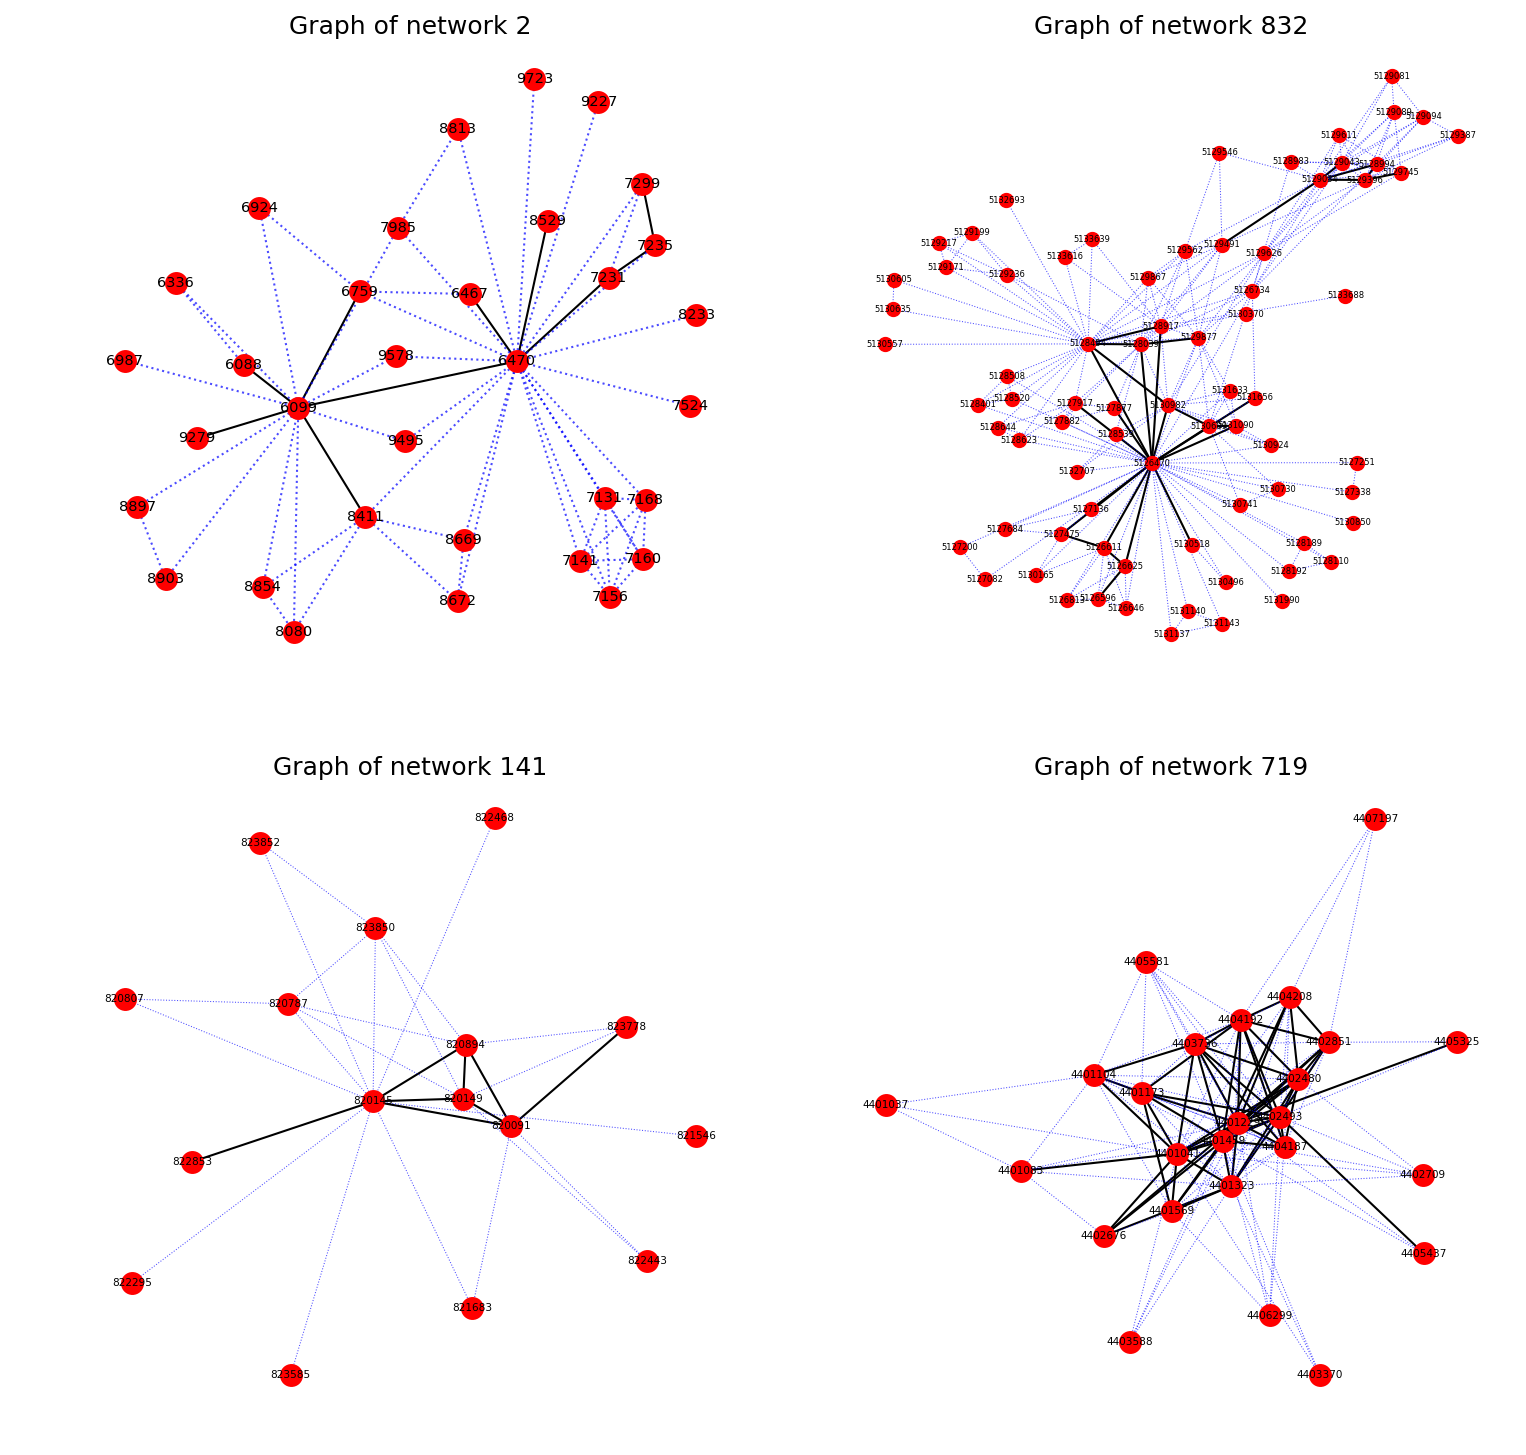

In [60]:
draw4graphs(score_node2vec)

# write to csv 

In [ ]:
myFile = open('../output/outputs-approach2.csv', 'w')  
with myFile:  
    myFields = ['graph_id']
    for k in range(2):
        for i in range(27):
            myFields.append('node_{}_{}'.format(k, i))
    
    for i in range(32):
        myFields.append('sum_{}'.format(i))
    
    for i in range(32):
        myFields.append('avg_{}'.format(i))
                
    writer = csv.DictWriter(myFile, fieldnames=myFields)    
    writer.writeheader()
    for j in graph_dict: 
        diction = {}
        diction['graph_id']=j
        for k in range(2):
            for i in range(27):
                att = 'node_{}_{}'.format(k, i)
                diction[att] = result_egonet_mostIndegree[j][k*27+i]
        
        for i in range(32):
            att = 'sum_{}'.format(i)
            diction[att] = result_node2vec[j][i]
    
        for i in range(32):
            att = 'avg_{}'.format(i)
            diction[att] = result_node2vec[j][32+i]
        
        
        writer.writerow(diction)

# process the central node selected due to centrality and get egonet

In [ ]:
# graph_dict is with both in and out edges
def load_central(file_name):
    df = pd.read_csv(file_name)
    central_nodes = {}
    for index, row in df.iterrows():
        central_nodes[row["graph_id"]] = row['central_node']
  
    return central_nodes


graph_dict = readGraph("../dataset/edges/")
central_nodes = load_central("../dataset/central_nodes.csv")

result_egonet_central = {}
for i in graph_dict:
    print i
    G = graph_dict[i]
    OutDegV = snap.TIntPrV()
    snap.GetNodeOutDegV(G, OutDegV)
    
    # degList = [(NodeId, NodeOutDegree)]
    degList = []
    for item in OutDegV:
        degList.append((item.GetVal1(), item.GetVal2()))
    # sorted degree of all the nodes in this graph, starting from the node with its max degree
    degList.sort(key=lambda x: x[1], reverse=True)
    
    nodeWithFeatures = getNodeWithFeatures(G, degList)
    
    nodeId0 = central_nodes[i]
    node0 = G.GetNI(nodeId0)
    newNodeWithFeatures = getRecursiveFeatures(2, nodeId0, G, nodeWithFeatures)
#     print "nodeId0 ", nodeId0
#     print "newNodeWithFeatures[nodeId0] ", newNodeWithFeatures[nodeId0]
    
    result_egonet_central[i] = []
    result_egonet_central[i].extend(newNodeWithFeatures[nodeId0])
    # break
    


In [ ]:
myFile = open('../output/outputs-central-nodes.csv', 'w')  
with myFile:  
    myFields = ['graph_id']
    for k in range(1):
        for i in range(27):
            myFields.append('node_{}_{}'.format(k, i))
                
    writer = csv.DictWriter(myFile, fieldnames=myFields)    
    writer.writeheader()
    for j in graph_dict: 
        diction = {}
        diction['graph_id']=j
        for k in range(1):
            for i in range(27):
                att = 'node_{}_{}'.format(k, i)
                diction[att] = result_egonet_central[j][k*27+i]
        
        
        writer.writerow(diction)

# save embeddings and check similarity between for AWE-DD

In [ ]:
def writeEmbeddingToCSV(filename, length, headername, dicntionary)
    myFile = open(filename, 'w')  
    with myFile:  
        myFields = ['graph_id']
        for i in range(length):
            myFields.append(headername.format(i))

        writer = csv.DictWriter(myFile, fieldnames=myFields)    
        writer.writeheader()
        k = 0
        for j in graph_dict: 
            diction = {}
            diction['graph_id']=j

            for i in range(length):
                att = headername.format(i)
                diction[att] = dicntionary[k][i]

            k+=1
            writer.writerow(diction)

In [28]:
embeddings_awedd = np.load("AWE-master/results/characterNetwork/embeddings.txt.npz")['E']

In [ ]:
writeEmbeddingToCSV('../output/outputs-embedding.csv', 128, 'embed_{}', embeddings_awedd)

In [37]:
result_awedd = {}
i = 0
for j in graph_dict: 
    result_awedd[j] = embeddings_awedd[i]
    i += 1
key2_awedd = result_awedd[2]
score_awedd = calculate_similarities(2, key2_awedd, 0, result_awedd)
score_awedd

[(749, 1.1788666),
 (686, 1.1844718),
 (314, 1.2020358),
 (330, 1.2103987),
 (61, 1.2184235),
 (206, 1.2234991),
 (453, 1.2314461),
 (832, 1.2324914),
 (415, 1.2339393),
 (30, 1.2364126),
 (279, 1.236672),
 (523, 1.2378701),
 (704, 1.2415073),
 (248, 1.2422832),
 (356, 1.2454814),
 (401, 1.2459811),
 (343, 1.2485142),
 (384, 1.2488173),
 (855, 1.2516329),
 (765, 1.255018),
 (226, 1.2555866),
 (728, 1.2581958),
 (323, 1.2585356),
 (647, 1.2590734),
 (551, 1.2594129),
 (44, 1.260491),
 (240, 1.2622836),
 (402, 1.263182),
 (327, 1.2646049),
 (179, 1.2650553),
 (124, 1.2651458),
 (500, 1.2663455),
 (533, 1.267138),
 (296, 1.2675532),
 (190, 1.2681416),
 (351, 1.2686205),
 (175, 1.2687216),
 (409, 1.2706956),
 (628, 1.271747),
 (594, 1.2725207),
 (461, 1.2725542),
 (138, 1.2731895),
 (300, 1.2738143),
 (787, 1.2740327),
 (418, 1.275744),
 (560, 1.2761706),
 (223, 1.277914),
 (134, 1.2783448),
 (790, 1.2803775),
 (435, 1.2817378),
 (762, 1.2830602),
 (396, 1.283917),
 (539, 1.2842933),
 (595

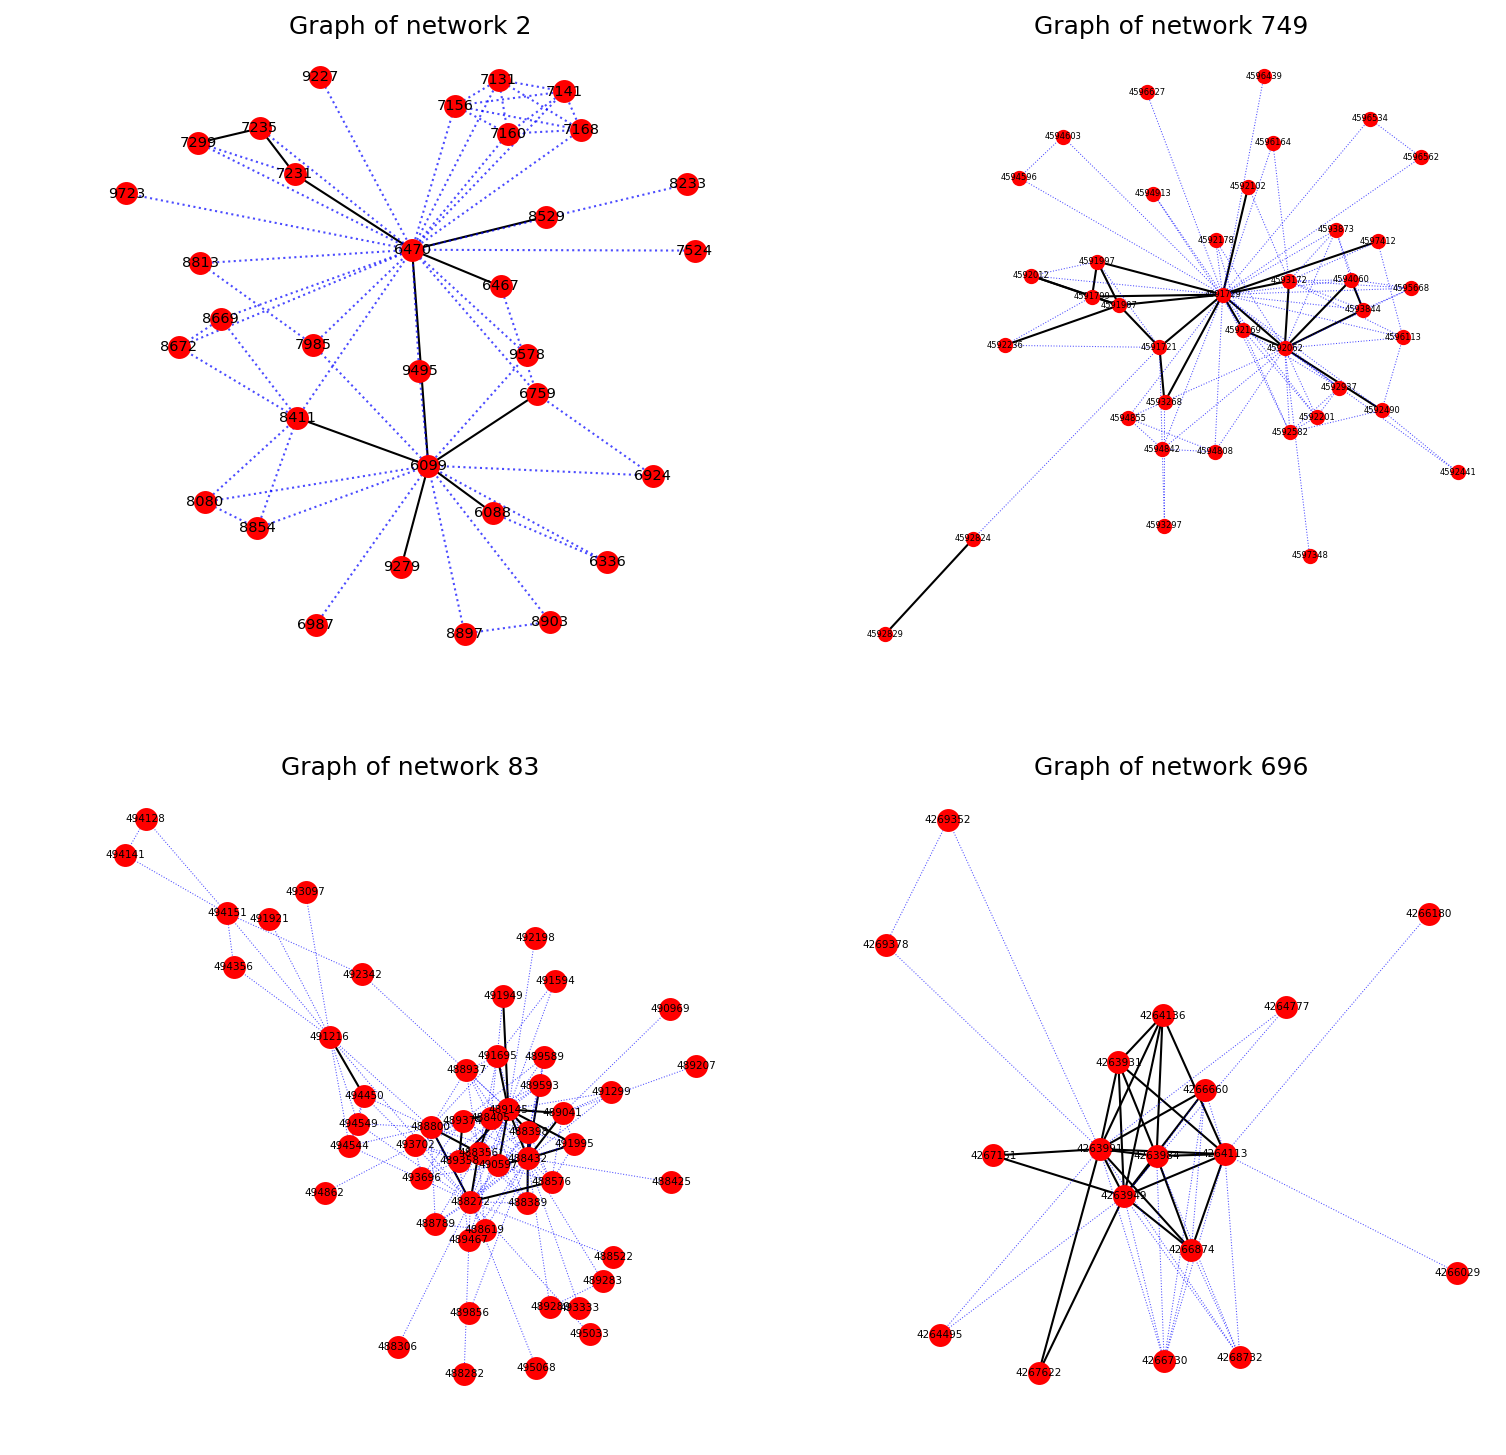

In [61]:
draw4graphs(score_awedd)

In [41]:
rank1 = [i[0] for i in score_node2vec]
rank2 = [i[0] for i in score_awedd]
from scipy.stats import kendalltau
from scipy.stats import spearmanr
print kendalltau(rank1, rank2)
print spearmanr(rank1, rank2)

KendalltauResult(correlation=0.00965706336565795, pvalue=0.6880003706952881)
SpearmanrResult(correlation=0.015551318147536618, pvalue=0.6661647773774362)


(773, 877)

# save embeddings and check similarity between for AWE-FB

In [46]:
embeddings_awefb = np.load("AWE-master/results/characterNetwork/embeddings_kernel_MC.txt.npz")['E']

In [51]:
writeEmbeddingToCSV('../output/outputs-embedding-awefb.csv', 877, 'embed_awefb_{}', embeddings_awefb)

In [52]:
result_awefb = {}
i = 0
for j in graph_dict: 
    result_awefb[j] = embeddings_awefb[i]
    i += 1
key2_awefb = result_awefb[2]
score_awefb = calculate_similarities(2, key2_awefb, 0, result_awefb)
score_awefb

[(837, 0.02738247614807718),
 (671, 0.02901723625709413),
 (319, 0.029049268493371742),
 (529, 0.029055808369412253),
 (309, 0.029932590933629547),
 (476, 0.029955633860761804),
 (372, 0.030580058861944738),
 (848, 0.03062352037242002),
 (445, 0.030878471464760283),
 (834, 0.031063483384836513),
 (804, 0.031144501922490346),
 (855, 0.031194550806190505),
 (125, 0.03181100438527519),
 (799, 0.03194276130831548),
 (651, 0.032318415802758765),
 (341, 0.03232367553357759),
 (474, 0.032733469110377104),
 (439, 0.03299424192188746),
 (491, 0.03302695868529221),
 (302, 0.03341795924349688),
 (383, 0.03383193757383716),
 (28, 0.03470244948126877),
 (211, 0.03480086205828818),
 (572, 0.03521902894743146),
 (454, 0.0360779711181216),
 (705, 0.03641730357948007),
 (862, 0.03687844899124707),
 (904, 0.03690555513740475),
 (578, 0.03765527851443951),
 (222, 0.037800793642462076),
 (371, 0.037983680706324664),
 (139, 0.038054171913208305),
 (515, 0.03822512262897261),
 (874, 0.03896511260088961),
 (

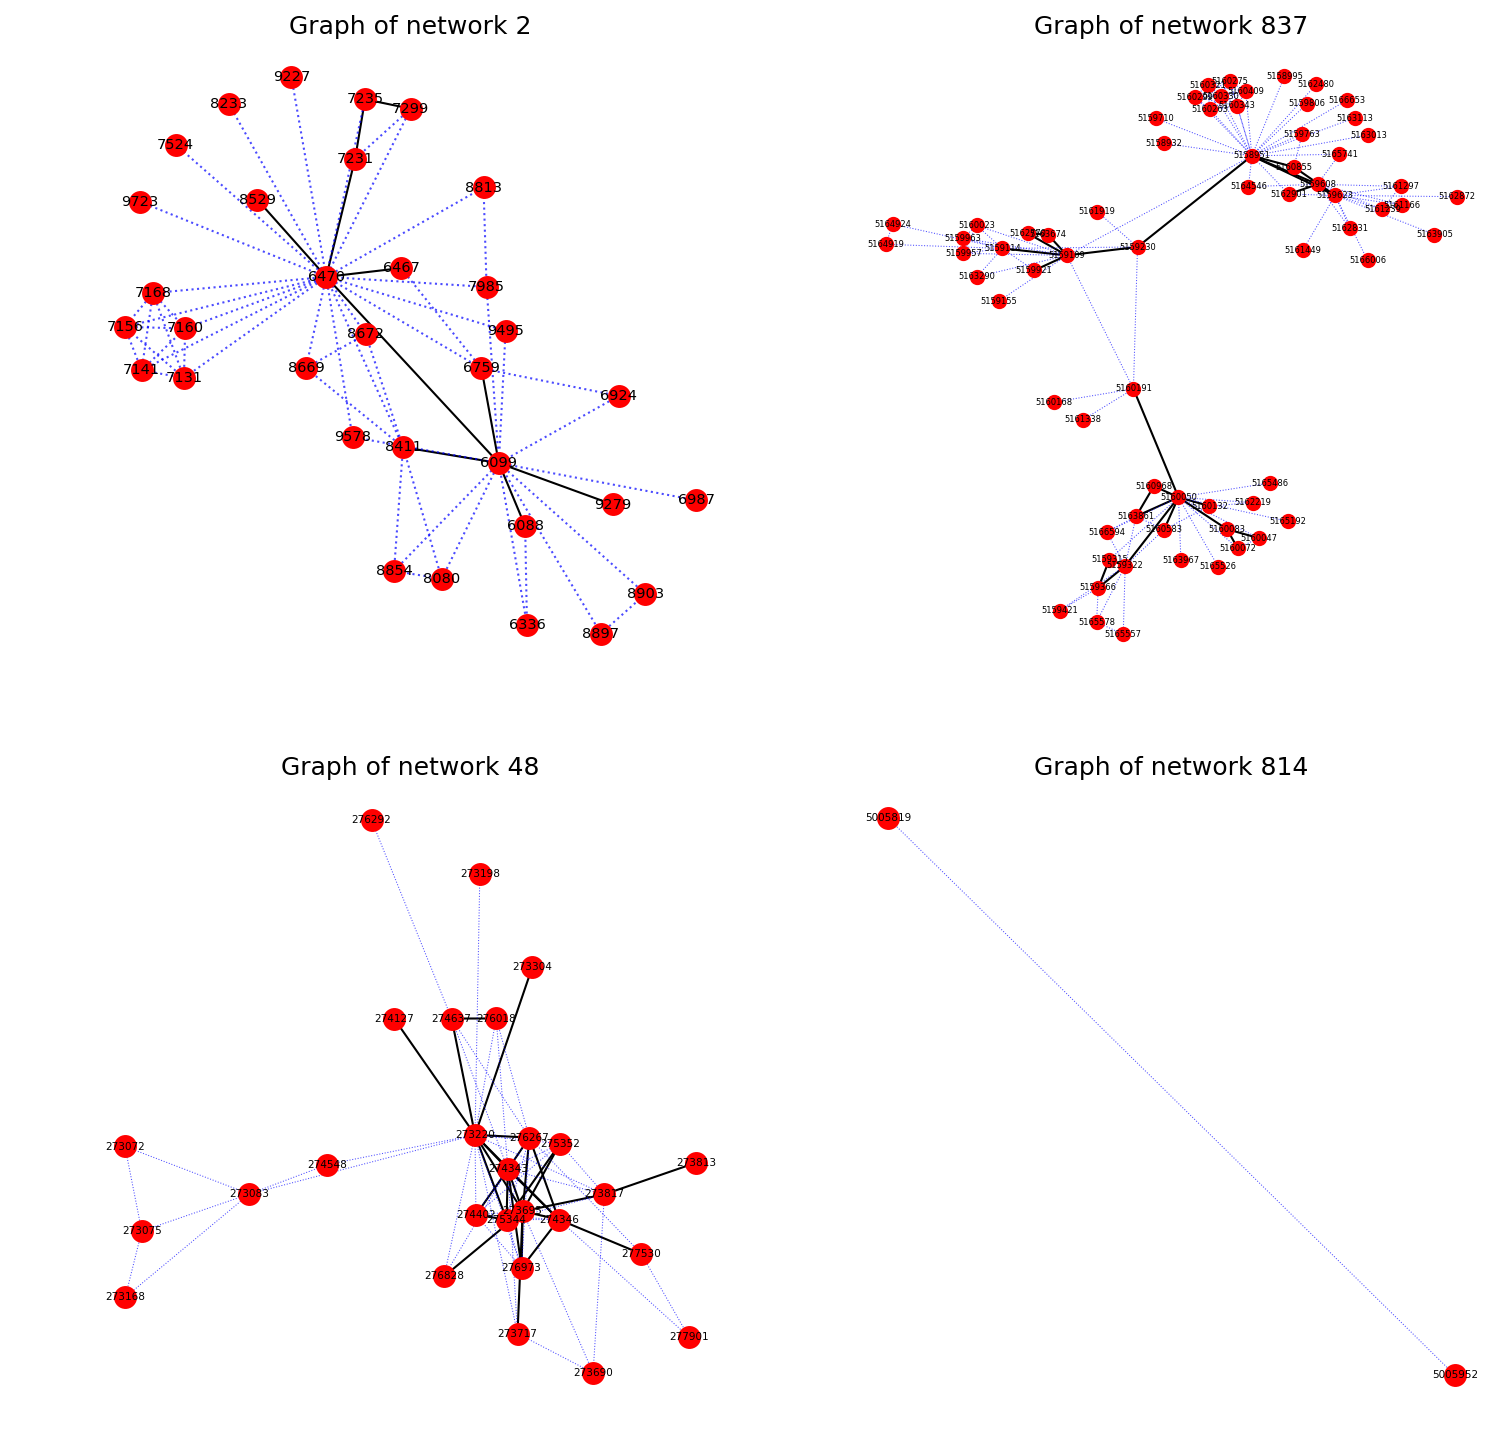

In [62]:
draw4graphs(score_awefb)

In [64]:
rank1 = [i[0] for i in score_node2vec]
rank2 = [i[0] for i in score_awedd]
rank3 = [i[0] for i in score_awefb]
from scipy.stats import kendalltau
from scipy.stats import spearmanr
print kendalltau(rank1, rank2)
print spearmanr(rank1, rank2)
print kendalltau(rank1, rank3)
print spearmanr(rank1, rank3)
print kendalltau(rank2, rank3)
print spearmanr(rank2, rank3)

KendalltauResult(correlation=0.00965706336565795, pvalue=0.6880003706952881)
SpearmanrResult(correlation=0.015551318147536618, pvalue=0.6661647773774362)
KendalltauResult(correlation=-0.027895942958139287, pvalue=0.24604941042046502)
SpearmanrResult(correlation=-0.04148872556689315, pvalue=0.2495728692513208)
KendalltauResult(correlation=-0.02594705751900164, pvalue=0.2806064929321943)
SpearmanrResult(correlation=-0.039010736466132984, pvalue=0.2790016831146474)


In [73]:
def draw3graphs(score1, score2, score3):
    # figure(num=None, figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')

    fig = plt.figure(figsize=(12,20), dpi=150)
    plt.subplot(4, 2, 1)

    G = nx.read_edgelist("../dataset/edges/2_edges.txt", comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    #nx.draw_networkx(G)
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1]
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=100)
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=1,alpha=0.7,edge_color='b',style='dotted')
    nx.draw_networkx_labels(G,pos,font_size=7,font_family='sans-serif')
    plt.axis('off')
    plt.title("Graph of network 2")

    plt.subplot(4, 2, 3)
    num1 = score1[0][0]
    G = nx.read_edgelist("../dataset/edges/{}_edges.txt".format(num1), comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1]
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=40)
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=0.5,alpha=0.7,edge_color='b',style='dotted')
    nx.draw_networkx_labels(G,pos,font_size=4,font_family='sans-serif')
    plt.axis('off')
    plt.title("Node2Vec: Graph of network {}".format(num1))

    plt.subplot(4, 2, 4)
    num2 = score1[-1][0]
    G = nx.read_edgelist("../dataset/edges/{}_edges.txt".format(num2), comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1]
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=100)
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=0.5,alpha=0.7,edge_color='b',style='dotted')
    nx.draw_networkx_labels(G,pos,font_size=5,font_family='sans-serif')
    plt.axis('off')
    plt.title("Node2Vec: Graph of network {}".format(num2))

    plt.subplot(4, 2, 5)
    num1 = score2[0][0]
    G = nx.read_edgelist("../dataset/edges/{}_edges.txt".format(num1), comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1]
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=40)
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=0.5,alpha=0.7,edge_color='b',style='dotted')
    nx.draw_networkx_labels(G,pos,font_size=4,font_family='sans-serif')
    plt.axis('off')
    plt.title("AWE-DD: Graph of network {}".format(num1))

    plt.subplot(4, 2, 6)
    num2 = score2[-1][0]
    G = nx.read_edgelist("../dataset/edges/{}_edges.txt".format(num2), comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1]
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=100)
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=0.5,alpha=0.7,edge_color='b',style='dotted')
    nx.draw_networkx_labels(G,pos,font_size=5,font_family='sans-serif')
    plt.axis('off')
    plt.title("AWE-DD: Graph of network {}".format(num2))
    
    plt.subplot(4, 2, 7)
    num1 = score3[0][0]
    G = nx.read_edgelist("../dataset/edges/{}_edges.txt".format(num1), comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1]
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=40)
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=0.5,alpha=0.7,edge_color='b',style='dotted')
    nx.draw_networkx_labels(G,pos,font_size=4,font_family='sans-serif')
    plt.axis('off')
    plt.title("AWE-FB: Graph of network {}".format(num1))

    plt.subplot(4, 2, 8)
    num2 = score3[-1][0]
    G = nx.read_edgelist("../dataset/edges/{}_edges.txt".format(num2), comments='s', delimiter= ',', nodetype=int, data=(('weight',float),), create_using=nx.Graph())
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >1]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1]
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=100)
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=1)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=0.5,alpha=0.7,edge_color='b',style='dotted')
    nx.draw_networkx_labels(G,pos,font_size=5,font_family='sans-serif')
    plt.axis('off')
    plt.title("AWE-FB: Graph of network {}".format(num2))
    
    plt.savefig("../graphs/3_embeddings_comparison.png", bbox_inches='tight') 
    plt.show() # display

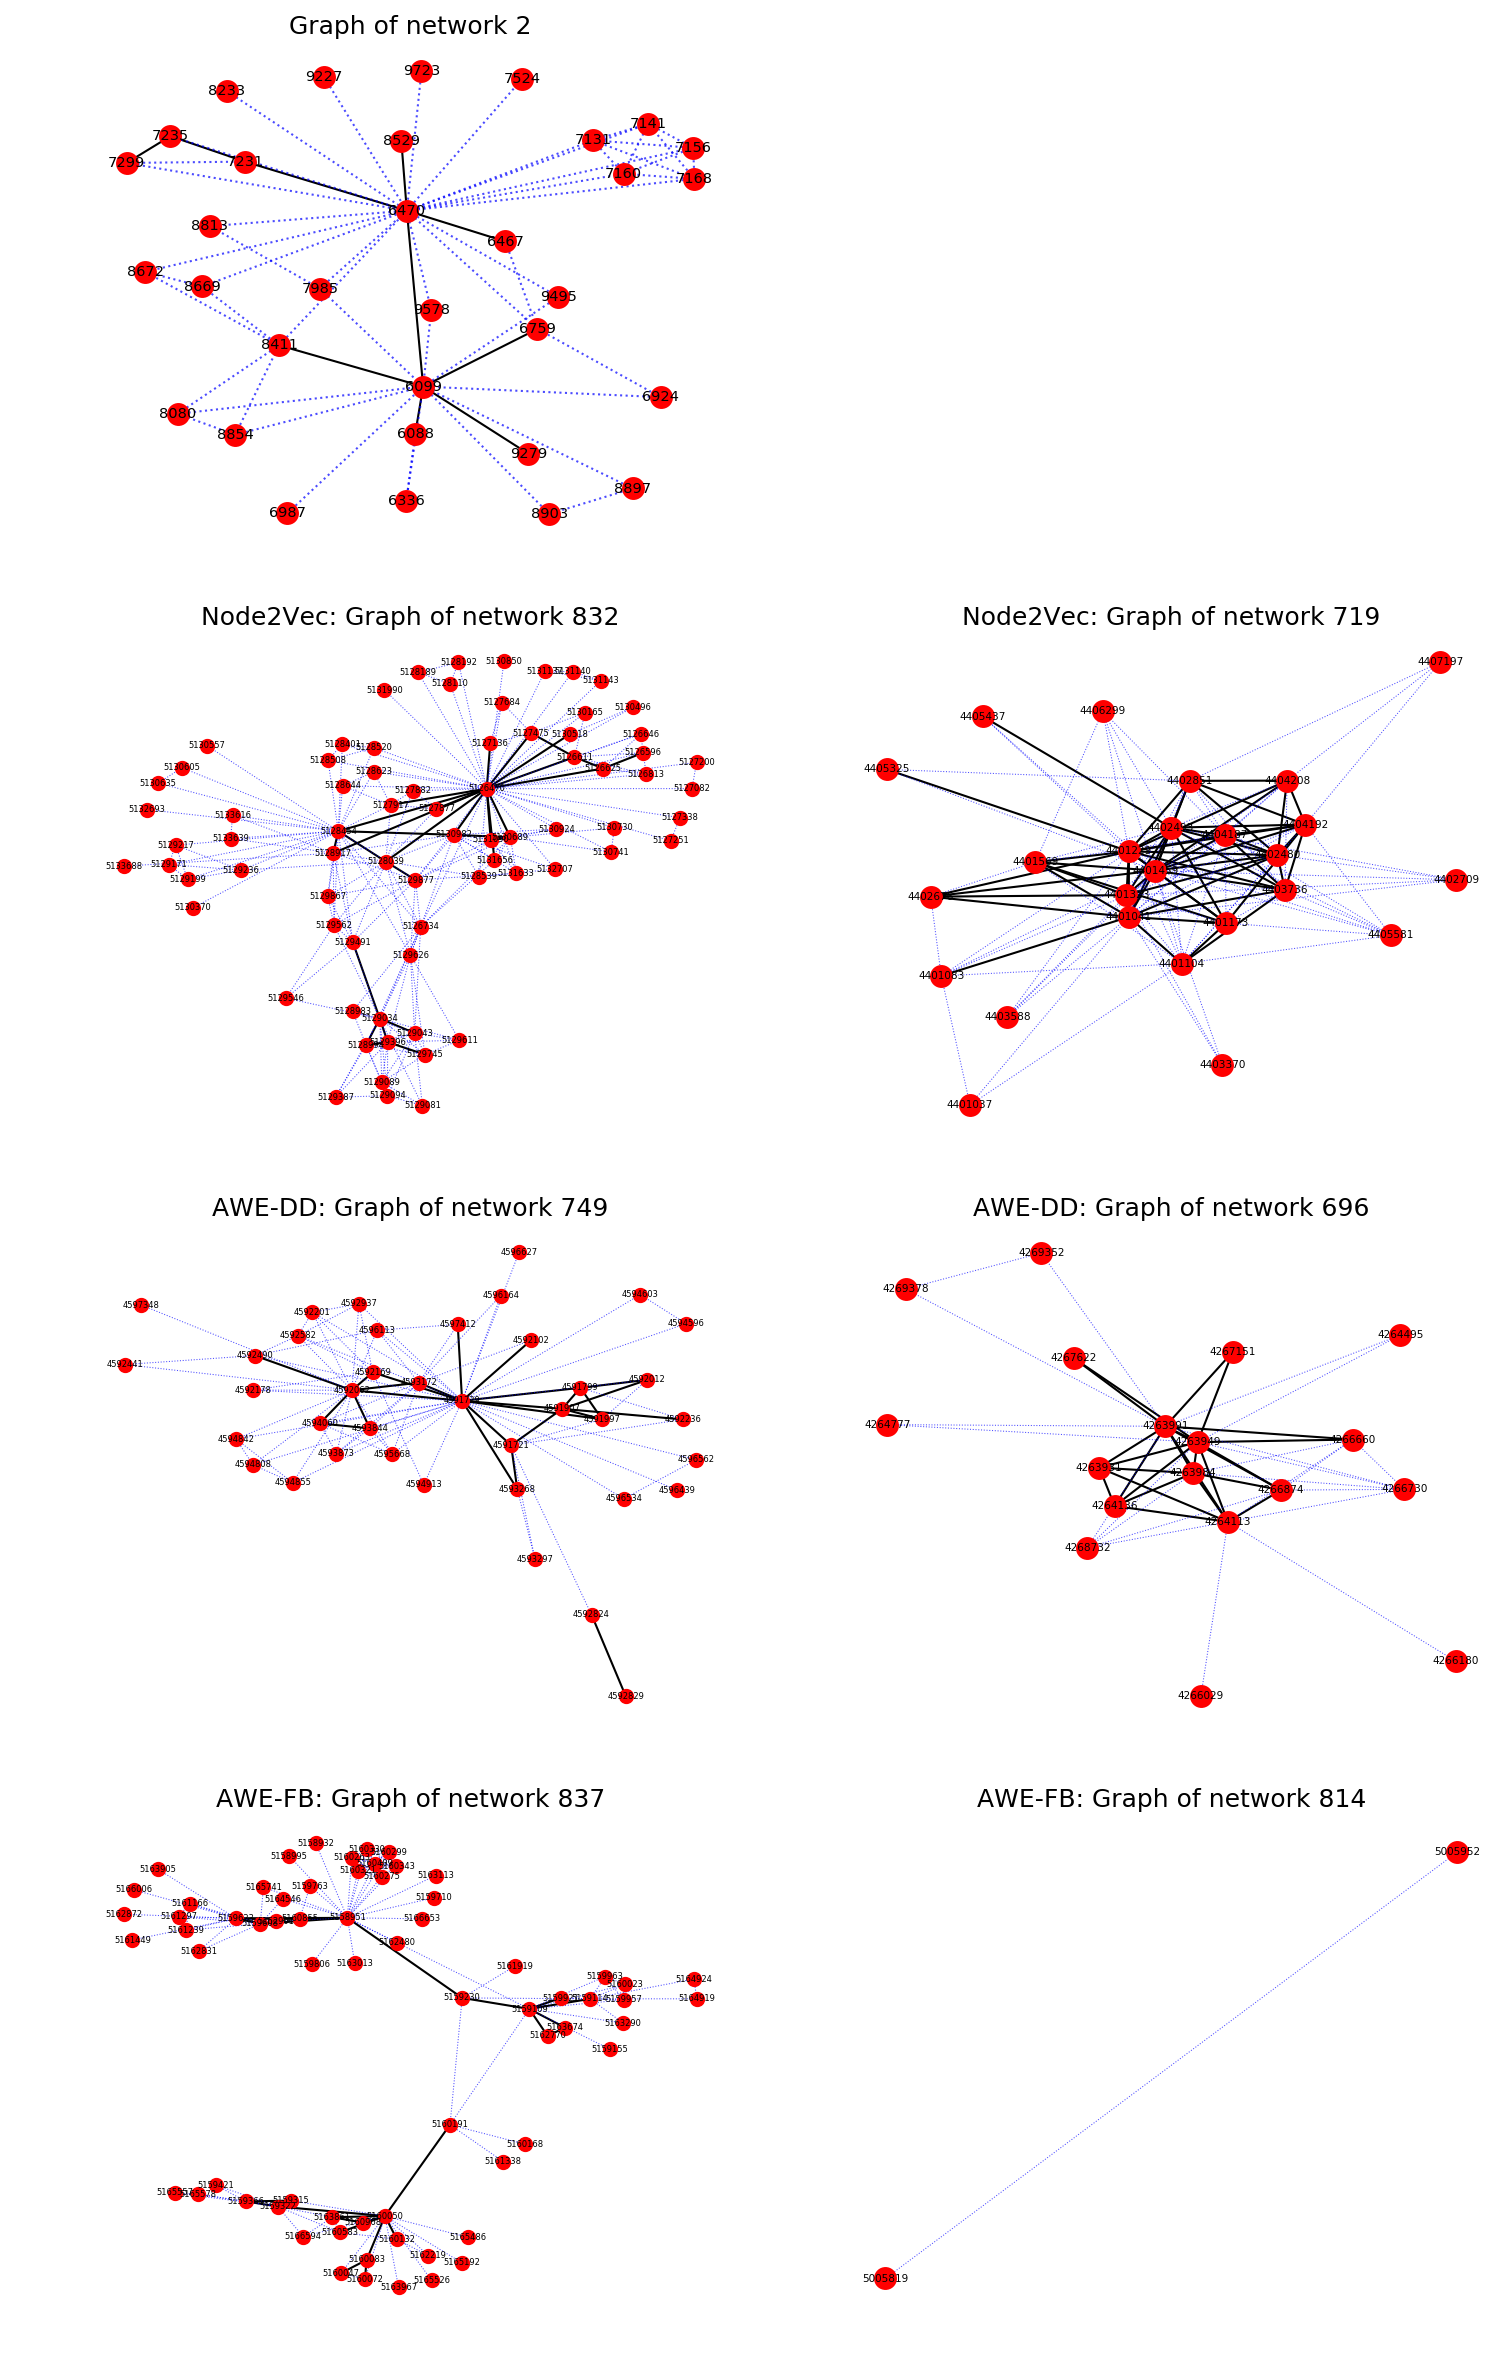

In [74]:
draw3graphs(score_node2vec, score_awedd, score_awefb)

In [63]:
embeddings_awefb_5 = np.load("AWE-master/results/characterNetwork/embeddings_kernel_MC_5.txt.npz")['E']
writeEmbeddingToCSV('../output/outputs-embedding-awefb-5.csv', 52, 'embed_awefb_5_{}', embeddings_awefb_5)